<a href="https://colab.research.google.com/github/Steven-Macas/coches-net-red-neuronal/blob/main/preprocesamiento_coches_net_scrappy_steven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scrappy Coches.NET**

---



In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
os.chdir('/content/drive/MyDrive/Scrapy_coches')

# **Importación de Librerias**

---



In [110]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf # importación de módulos de keras y gráficos
from IPython.display import SVG
import livelossplot
import math

# **Importación de datasets**

---



In [67]:
coches_csv = [f for f in os.listdir('/content/drive/MyDrive/Scrapy_coches') if f.endswith('.csv')]

df_coches_csv = pd.concat([pd.read_csv(os.path.join('/content/drive/MyDrive/Scrapy_coches', f)) for f in coches_csv])
cols_to_select = ['color', 'fueltype', 'km', 'make', 'model', 'price', 'province', 'transmissiontype', 'year', 'seller_type', 'bodytype', 'cubiccapacity', 'doors', 'hp']

df_coches_csv = df_coches_csv.rename(columns=lambda x: x.lower())
df_coches_csv = df_coches_csv.set_index('id')
df_coches_csv = df_coches_csv[cols_to_select]

In [68]:
# Obtener la lista de archivos JSON
coches_json = [f for f in os.listdir('/content/drive/MyDrive/Scrapy_coches') if f.endswith('.json')]

# Crear un DataFrame vacío para concatenar los resultados
df_coches_json = []

# Leer cada archivo JSON y concatenar el resultado
for f in coches_json:
    with open(os.path.join('/content/drive/MyDrive/Scrapy_coches', f), 'r') as file:
        data = json.load(file)
        if 'resto_de_datos' in data:
            df_temporary = pd.json_normalize(data['resto_de_datos'], max_level=1)
            df_temporary = df_temporary.rename(columns=lambda x: x.split('.')[-1])
            df = pd.json_normalize(data)
            df = pd.concat([df, df_temporary], axis=1)
        else:
            df = pd.json_normalize(data)
            # Buscamos si alguna columna contiene el texto 'resto_de_datos'
            if 'resto_de_datos.color' in list(df.columns):
                df = df.rename(columns=lambda x: x.split('.')[-1])
        df = df.rename(columns=lambda x: x.lower())
        df = df.drop_duplicates()
        df = df.set_index('id')
        # print(f,'b:', df.values[0])
        cols_to_select = ['color', 'fueltype', 'km', 'make', 'model', 'price', 'province', 'transmissiontype', 'year', 'seller_type', 'bodytype', 'cubiccapacity', 'doors', 'hp']
        df = df[cols_to_select]
        df_coches_json.append(df)

df_coches_json = pd.concat(df_coches_json)

# **Preprocesamiento**

---



In [69]:
df_coches_csv

,color,fueltype,km,make,model,price,province,transmissiontype,year,seller_type,bodytype,cubiccapacity,doors,hp
id,,,,,,,,,,,,,,
54737521,BLUE,Diésel,34798.0,AUDI,A3,22500.0,Almería,AUTOMATIC,2017.0,profesional,Berlina,1598.0,5.0,116.0
54641610,RED,Gasolina,178000.0,AUDI,A1,8990.0,Alicante,MANUAL,2014.0,particular,Berlina,1197.0,3.0,86.0
54229249,GRAY,Gasolina,93000.0,AUDI,Q2,24650.0,Alicante,MANUAL,2019.0,profesional,4x4 SUV,999.0,5.0,116.0
54534381,GRAY,Diésel,133000.0,AUDI,A4,21500.0,Asturias,MANUAL,2016.0,particular,Familiar,1968.0,5.0,190.0
54819626,WHITE,Diésel,65000.0,AUDI,Q3,23700.0,Alicante,MANUAL,2017.0,particular,4x4 SUV,1968.0,5.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54741384.0,COMMON.COLOR_RED,Diésel,69000.0,MAZDA,CX5,24999.0,Madrid,COMMON.TRANSMISSION_AUTOMATIC,2019.0,profesional,NaN,2191.0,5.0,150.0
54741045.0,COMMON.COLOR_WHITE,Gasolina,63912.0,MAZDA,MX5,19400.0,Madrid,COMMON.TRANSMISSION_MANUAL,2016.0,profesional,NaN,1998.0,2.0,160.0
54742715.0,COMMON.COLOR_BLUE,Gasolina,47000.0,MAZDA,Mazda2,10500.0,Barcelona,COMMON.TRANSMISSION_MANUAL,2015.0,particular,NaN,NaN,5.0,NaN


In [70]:
df_coches_json

,color,fueltype,km,make,model,price,province,transmissiontype,year,seller_type,bodytype,cubiccapacity,doors,hp
id,,,,,,,,,,,,,,
53966983,COMMON.COLOR_WHITE,Diésel,180000,VOLKSWAGEN,Golf,13990,Guipúzcoa,COMMON.TRANSMISSION_AUTOMATIC,2016,particular,BODY_TYPE_SEDAN,1598.0,5,110.0
54582825,COMMON.COLOR_WHITE,Diésel,34000,VOLKSWAGEN,Multivan,68000,A Coruña,COMMON.TRANSMISSION_MANUAL,2020,particular,BODY_TYPE_MINIVAN,1968.0,5,150.0
54789933,COMMON.COLOR_RED,Diésel,70000,VOLKSWAGEN,Caravelle,36900,Asturias,COMMON.TRANSMISSION_AUTOMATIC,2021,profesional,BODY_TYPE_MINIVAN,1968.0,4,150.0
54726003,COMMON.COLOR_GRAY,Diésel,66855,VOLKSWAGEN,Tiguan,33500,Madrid,COMMON.TRANSMISSION_AUTOMATIC,2019,profesional,BODY_TYPE_4X4,1968.0,5,150.0
54133083,COMMON.COLOR_WHITE,Gasolina,89000,VOLKSWAGEN,Polo,16500,Barcelona,COMMON.TRANSMISSION_MANUAL,2015,profesional,BODY_TYPE_SEDAN,1798.0,3,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54828570,COMMON.COLOR_BLACK,Gasolina,80000,PORSCHE,Panamera,53900,Madrid,COMMON.TRANSMISSION_AUTOMATIC,2013,profesional,BODY_TYPE_SEDAN,4806.0,5,570.0
54783072,COMMON.COLOR_WHITE,Gasolina,85000,PORSCHE,Cayenne,69900,Barcelona,COMMON.TRANSMISSION_AUTOMATIC,2018,profesional,BODY_TYPE_4X4,2995.0,5,340.0
54072902,COMMON.COLOR_BLACK,Gasolina,10000,PORSCHE,Macan,119900,Barcelona,COMMON.TRANSMISSION_AUTOMATIC,2022,profesional,BODY_TYPE_4X4,2894.0,5,440.0


# **Preprocesamiento de los datos**

---



In [71]:
df = pd.concat([df_coches_csv, df_coches_json])

In [72]:
df.drop_duplicates(inplace=True)

In [73]:
df.count()

color               12855
fueltype            12857
km                  12857
make                12857
model               12857
price               12857
province            12857
transmissiontype    12854
year                12857
seller_type         12857
bodytype            10724
cubiccapacity       12421
doors               12847
hp                  12628
dtype: int64

In [74]:
df.dtypes

color               object
fueltype            object
km                  object
make                object
model               object
price               object
province            object
transmissiontype    object
year                object
seller_type         object
bodytype            object
cubiccapacity       object
doors               object
hp                  object
dtype: object

In [75]:
df.isnull().sum()

color                  3
fueltype               1
km                     1
make                   1
model                  1
price                  1
province               1
transmissiontype       4
year                   1
seller_type            1
bodytype            2134
cubiccapacity        437
doors                 11
hp                   230
dtype: int64

Hay columnas que tienen un minimo de valores nulos que si eliminamos no puede afectar a nuestro estudio, por ejemplo: color,fueltype,km...Pero campos como bodytype,cubiccapacity,hp ya contiene un gran contenido de valores nulos que debemos apreciar si eliminarlos sería buena idea o reemplazarlos por la media,moda...

In [42]:
df.dropna(subset=['color'], inplace=True)

In [43]:
df.dropna(subset=['fueltype'], inplace=True)

In [45]:
df.dropna(subset=['km'], inplace=True)

In [46]:
df.dropna(subset=['make'], inplace=True)

In [47]:
df.dropna(subset=['model'], inplace=True)

In [48]:
df.dropna(subset=['price'], inplace=True)

In [49]:
df.dropna(subset=['province'], inplace=True)

In [50]:
df.dropna(subset=['transmissiontype'], inplace=True)

In [51]:
df.dropna(subset=['year'], inplace=True)

In [52]:
df.dropna(subset=['seller_type'], inplace=True)

In [53]:
df.dropna(subset=['doors'], inplace=True)

In [76]:
df.fillna(df.mode().iloc[0], inplace=True)

In [77]:
df.isnull().sum()

color               0
fueltype            0
km                  0
make                0
model               0
price               0
province            0
transmissiontype    0
year                0
seller_type         0
bodytype            0
cubiccapacity       0
doors               0
hp                  0
dtype: int64

In [78]:
for col in df.columns:
    if isinstance(df[col][0], (int, float)):
        df[col] = df[col].astype(float)

In [79]:
df.dtypes

color                object
fueltype             object
km                  float64
make                 object
model                object
price               float64
province             object
transmissiontype     object
year                float64
seller_type          object
bodytype             object
cubiccapacity       float64
doors               float64
hp                  float64
dtype: object

In [80]:
col_numericos = []

col_categoricos = []
for columna in df.columns:
    if df[columna].dtype == 'int64' or df[columna].dtype == 'float64':
        col_numericos.append(columna)
    else:
        col_categoricos.append(columna)
print('col_numericos',col_numericos)
col_numericos.remove('price')
all_feature_names = col_numericos + col_categoricos

TG = 'price'
all_feature_names

col_numericos ['km', 'price', 'year', 'cubiccapacity', 'doors', 'hp']


['km',
 'year',
 'cubiccapacity',
 'doors',
 'hp',
 'color',
 'fueltype',
 'make',
 'model',
 'province',
 'transmissiontype',
 'seller_type',
 'bodytype']

<ipython-input-81-f27cba2ab741>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[col_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())


array([[<Axes: title={'center': 'km'}>, <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'cubiccapacity'}>,
        <Axes: title={'center': 'doors'}>],
       [<Axes: title={'center': 'hp'}>, <Axes: >]], dtype=object)

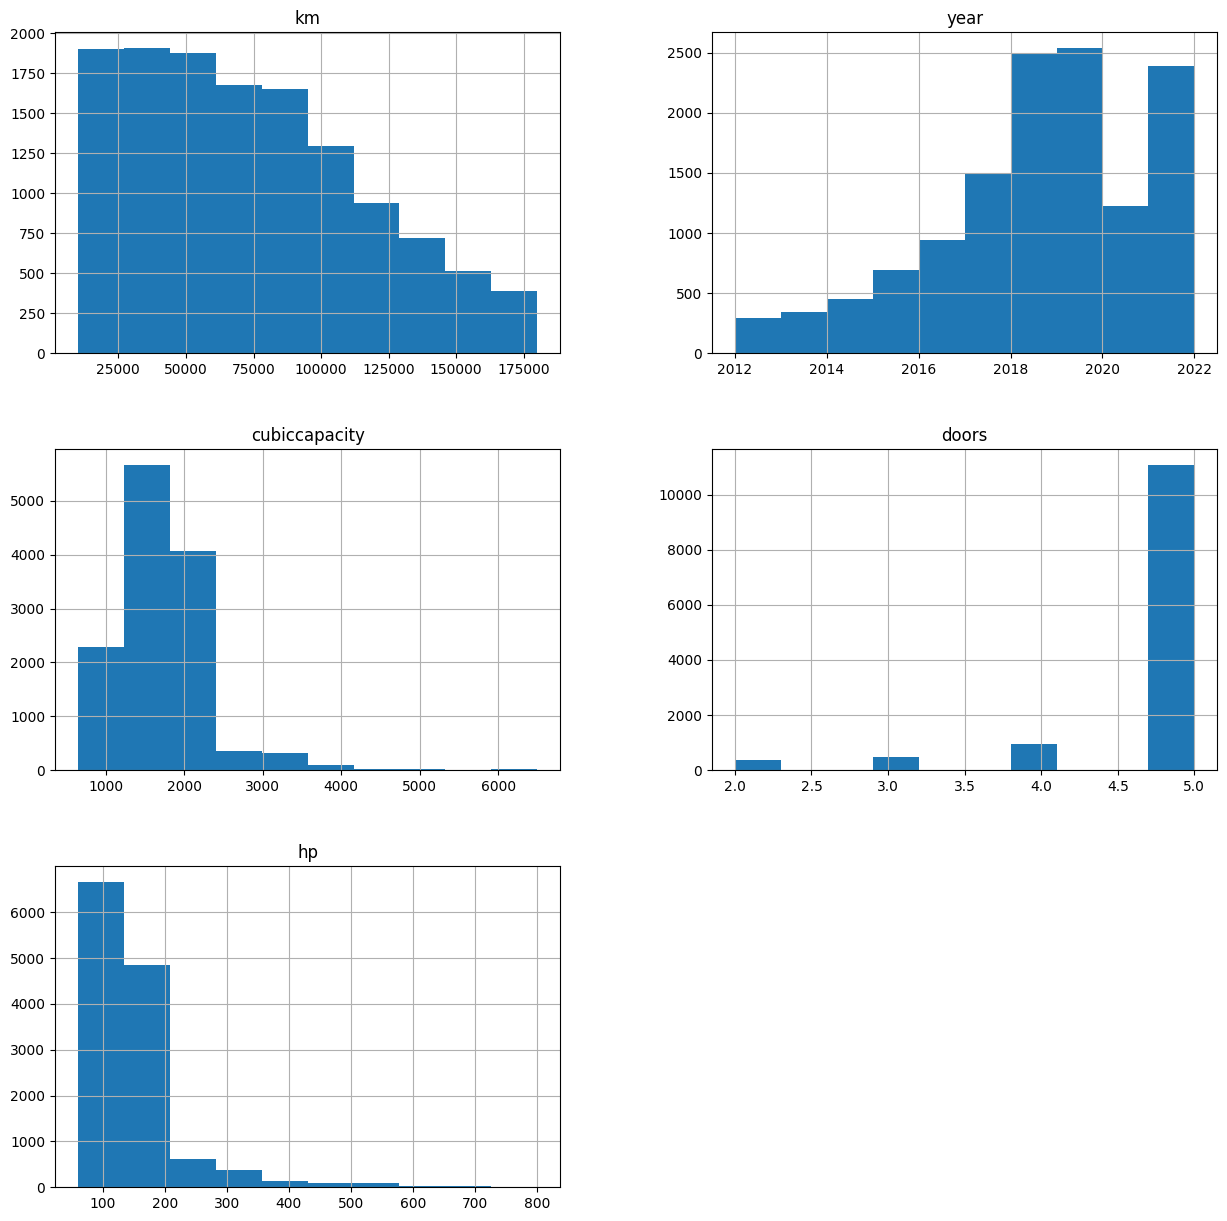

In [81]:
import matplotlib.pyplot as plt
df[col_numericos].hist(ax=plt.figure(figsize=(15,15)).gca())

In [83]:
import seaborn as sns

# mediante esta función de pueden visualizar los 'outliers'
def draw_hist_boxplot(df, feature_name):
  # se dibuja el diagrama de cajas
  sns.boxplot(x = feature_name, data = df)
  # se dibujan sobre el diagrama todos los puntos de datos que tiene la propiedad
  sns.stripplot(x = feature_name, data = df, color = "#474646")

# mediante esta función se reemplazan todos los outliers
# cualquier valor por encima o por debajo de los
# límites superior o inferior es sustituido por la mediana
def replace_outliers_with_median(df, feature_name):
  Q1 = df[feature_name].quantile(0.25)
  median = df[feature_name].quantile(0.5)
  Q3 = df[feature_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_whisker = Q1 - 1.5 * IQR
  upper_whisker = Q3 + 1.5 * IQR
  df[feature_name] = np.where((df[feature_name] < lower_whisker) | 
                              (df[feature_name] > upper_whisker), 
                                median, 
                                df[feature_name])

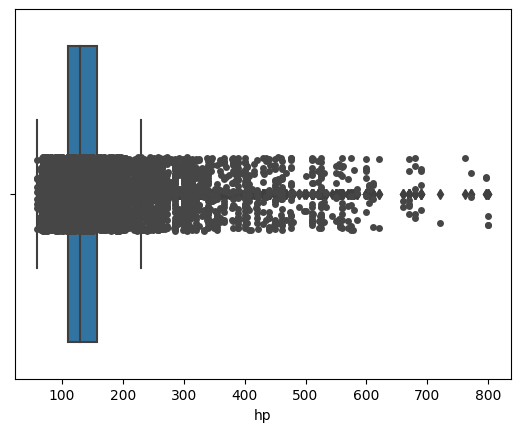

In [84]:
draw_hist_boxplot(df, 'hp')

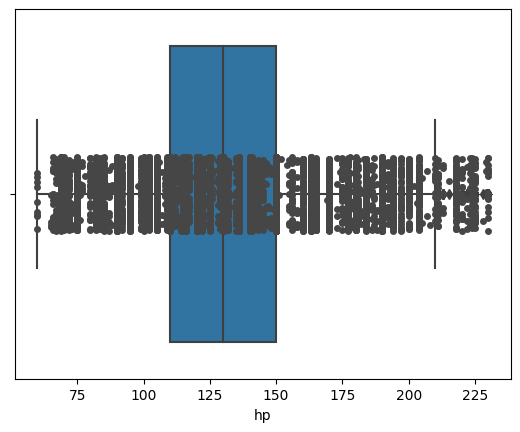

In [85]:
# se reemplazan los outliers y se vuelve a dibujar
replace_outliers_with_median(df, 'hp')
draw_hist_boxplot(df, 'hp')

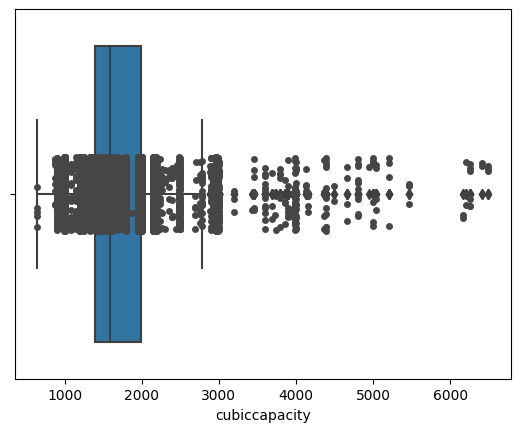

In [86]:
draw_hist_boxplot(df, 'cubiccapacity')

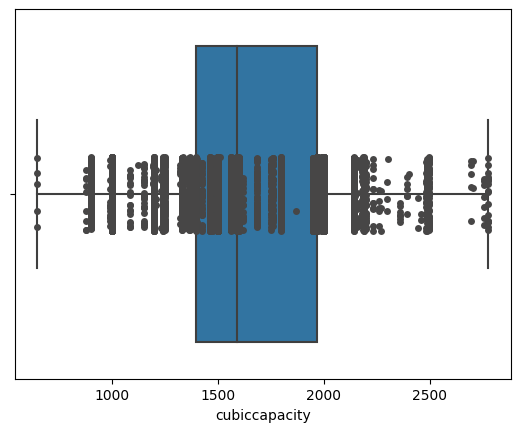

In [87]:
# se reemplazan los outliers y se vuelve a dibujar
replace_outliers_with_median(df, 'cubiccapacity')
draw_hist_boxplot(df, 'cubiccapacity')

calculamos la desviación de la distribución

In [88]:
print(df['km'].skew())

0.5130370648175218


Una vez limpiado los outliers hacemos un escalado de los datos

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[col_numericos] = scaler.fit_transform(df[col_numericos])

<ipython-input-91-f24fbff0441b>:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[col_numericos].hist(ax=plt.figure(figsize=(10,10)).gca())


array([[<Axes: title={'center': 'km'}>, <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'cubiccapacity'}>,
        <Axes: title={'center': 'doors'}>],
       [<Axes: title={'center': 'hp'}>, <Axes: >]], dtype=object)

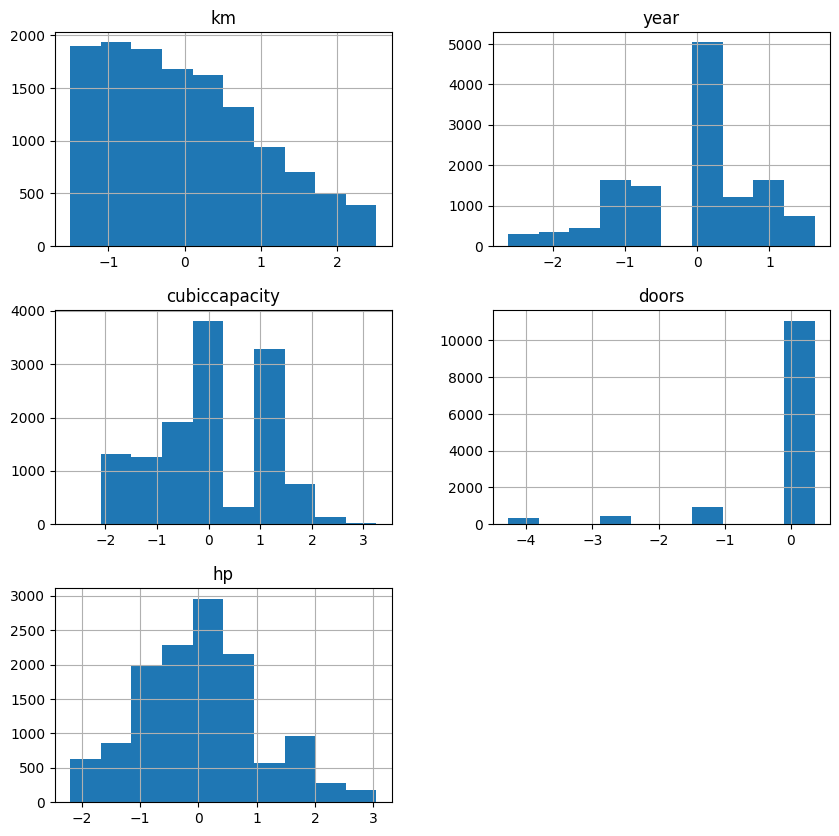

In [91]:
df[col_numericos].hist(ax=plt.figure(figsize=(10,10)).gca())

# **Datos de Entrenamiento/Test**



---



<ipython-input-95-2bbd277cb826>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='coolwarm', center=0, annot=True)


<Axes: >

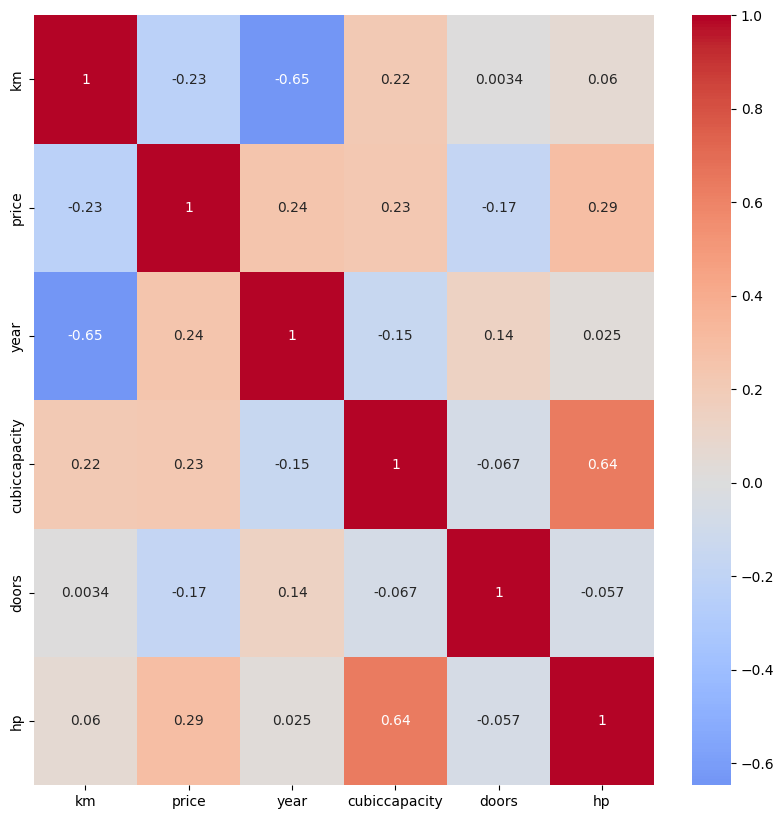

In [95]:
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0, annot=True)

In [96]:
cars_features = all_feature_names + [TG]

In [98]:
df_TG = df['price']
df = df.drop('price', axis=1)

In [99]:
df[9:10].to_dict(orient='records')

[{'color': 'GRAY',
  'fueltype': 'Diésel',
  'km': -0.23345577925062735,
  'make': 'AUDI',
  'model': 'Q3',
  'province': 'Barcelona',
  'transmissiontype': 'AUTOMATIC',
  'year': 0.3518986830302952,
  'seller_type': 'particular',
  'bodytype': '4x4 SUV',
  'cubiccapacity': 0.9991277301485647,
  'doors': 0.3561954893951225,
  'hp': 0.5838766158488538}]

In [101]:
# Iterar a través de cada columna
colms_categoricas = []
for column in df.columns:
    if df[column].dtype in ['object', 'category', 'bool']:
        print(f'Únicos de la columna "{column}":')
        print(df[column].unique())
        colms_categoricas.append(column)

Únicos de la columna "color":
['BLUE' 'RED' 'GRAY' 'WHITE' 'BLACK' 'YELLOW' 'ORANGE' 'BROWN' 'GREEN'
 'GARNET' 'COMMON.COLOR_BLACK' 'COMMON.COLOR_WHITE' 'COMMON.COLOR_BLUE'
 'COMMON.COLOR_GRAY' 'COMMON.COLOR_BEIGE' 'COMMON.COLOR_ORANGE'
 'COMMON.COLOR_BROWN' 'COMMON.COLOR_RED' 'COMMON.COLOR_YELLOW'
 'COMMON.COLOR_GREEN' 'COMMON.COLOR_GARNET' 'COMMON.COLOR_PURPLE'
 'COMMON.COLOR_PINK']
Únicos de la columna "fueltype":
['Diésel' 'Gasolina' 'Híbrido' 'Híbrido enchufable' 'Gas natural (CNG)'
 'Eléctrico' 'Di\\u00E9sel' 'Gas licuado (GLP)' 'El\\u00E9ctrico'
 'H\\u00EDbrido' 'H\\u00EDbrido enchufable']
Únicos de la columna "make":
['AUDI' 'BMW' 'MERCEDES-BENZ' 'MAZDA' 'VOLKSWAGEN' 'PEUGEOT' 'SSANGYONG'
 'OPEL' 'RENAULT' 'HONDA' 'HYUNDAI' 'JAGUAR' 'JEEP' 'KIA' 'SMART' 'TOYOTA'
 'LAND-ROVER' 'LEXUS' 'TESLA' 'SUZUKI' 'SEAT' 'SKODA' 'VOLVO' 'FORD'
 'FIAT' 'DS' 'FERRARI' 'SUBARU' 'ABARTH' 'ALFA ROMEO' 'CHEVROLET'
 'CITROEN' 'CUPRA' 'DACIA' 'MINI' 'MITSUBISHI' 'NISSAN' 'PORSCHE']
Únicos de la colu

In [102]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train, y_test = train_test_split(df,df_TG,random_state=1,train_size=0.80)

In [103]:
train_dict = x_train[all_feature_names].to_dict(orient='records')
test_dict = x_test[all_feature_names].to_dict(orient='records')

In [105]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse = False)
dv.fit(df.to_dict(orient='records'))
X_train = dv.transform(train_dict)

In [107]:
X_test = dv.transform(test_dict)

# **Creación de Red Neuronal**

---



## **Definir modelo**

In [108]:
!pip install keras tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
# instalación de librería gráfica para ver cómo evoluciona la función de pérdida
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
plot_losses = livelossplot.PlotLossesKeras()

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Definimos el modelo de Keras
model = Sequential()
input_shape = len(X_train[0])
print('Numero de entradas:',input_shape)

model.add(Dense(X_train.shape[1], input_shape=(input_shape,), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(X_train.shape[1]*2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

model.summary()

Numero de entradas: 636
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 636)               405132    
                                                                 
 dense_3 (Dense)             (None, 1272)              810264    
                                                                 
 dense_4 (Dense)             (None, 1)                 1273      
                                                                 
Total params: 1,216,669
Trainable params: 1,216,669
Non-trainable params: 0
_________________________________________________________________


In [113]:
batch_size = int(math.sqrt(len(x_train)))

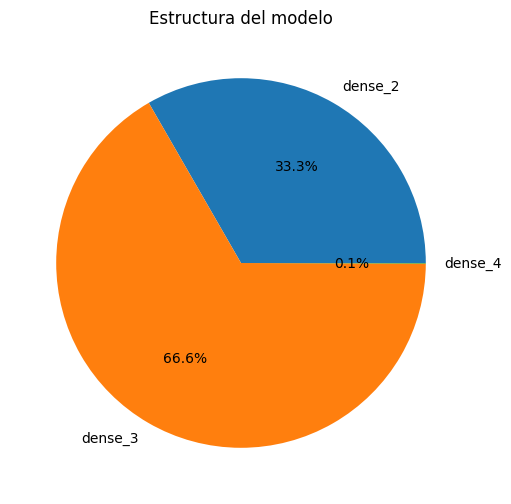

In [132]:
import matplotlib.pyplot as plt

# Obtener la estructura del modelo
model_layers = [layer.output for layer in model.layers]
layer_names = [layer.name for layer in model.layers]

# Crear el diagrama
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Estructura del modelo')
ax.axis('off')
_ = plt.pie([layer.shape[-1] for layer in model_layers], labels=layer_names, autopct='%1.1f%%')
plt.show()

## **Entrenar Modelo**

In [118]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import math

# Definir el optimizador
optimizer = Adam(learning_rate=0.01)

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Definir early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=0)

# Definir reducción del learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=0.001, mode='min', verbose=0)

batch_size=int(math.sqrt(len(X_train)))
print("batch_size:",batch_size)

# Entrenar el modelo con reducción del learning rate
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5000, batch_size=batch_size, callbacks=[early_stop,reduce_lr])

batch_size: 101
Epoch 1/5000
102/102 [==============================] - 5s 35ms/step - loss: 299094976.0000 - val_loss: 265427200.0000 - lr: 0.0100
Epoch 2/5000
102/102 [==============================] - 4s 44ms/step - loss: 118612416.0000 - val_loss: 175032896.0000 - lr: 0.0100
Epoch 3/5000
102/102 [==============================] - 7s 71ms/step - loss: 66407020.0000 - val_loss: 93936432.0000 - lr: 0.0100
Epoch 4/5000
102/102 [==============================] - 6s 58ms/step - loss: 39339284.0000 - val_loss: 59214396.0000 - lr: 0.0100
Epoch 5/5000
102/102 [==============================] - 3s 32ms/step - loss: 28268348.0000 - val_loss: 42974160.0000 - lr: 0.0100
Epoch 6/5000
102/102 [==============================] - 4s 39ms/step - loss: 23531850.0000 - val_loss: 43206236.0000 - lr: 0.0100
Epoch 7/5000
102/102 [==============================] - 4s 40ms/step - loss: 21674402.0000 - val_loss: 40269968.0000 - lr: 0.0100
Epoch 8/5000
102/102 [==============================] - 3s 30ms/step -

In [120]:
test_loss = model.evaluate(X_test, y_test)

81/81 [==============================] - 1s 11ms/step - loss: 27618302.0000


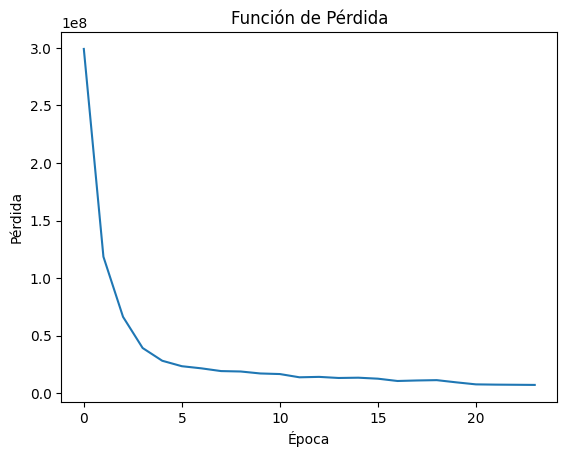

In [119]:
plt.plot(history.history['loss'])
plt.title('Función de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

In [123]:
test = {'color': 'WHITE', 'fueltype': 'Gasolina', 'km': '34798', 'make': 'AUDI', 'model': 'A1', 'province': 'Melilla', 'transmissiontype': 'AUTOMATIC', 'year': '2017', 'seller_type': 'profesional', 'bodytype': 'Berlina', 'cubiccapacity': '1598', 'doors': '5', 'hp': '116'}
test = dv.transform([dict(test)])
model.predict(test)

1/1 [==============================] - 0s 50ms/step


array([[11123.663]], dtype=float32)

81/81 [==============================] - 1s 13ms/step


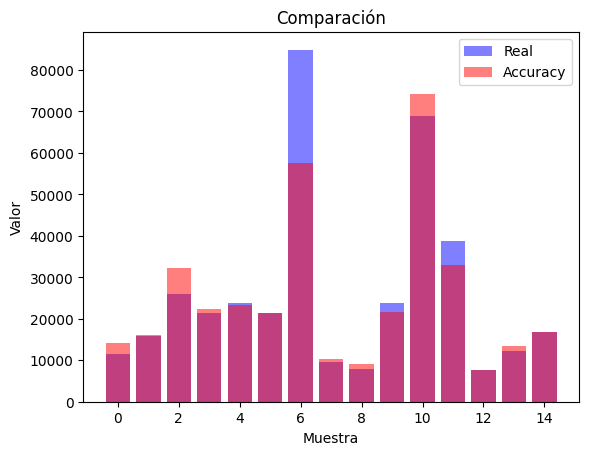

In [125]:
y_pred = model.predict(X_test)
import numpy as np

# Crear un array de índices para los datos de prueba
indices = np.arange(15)

# Crear un gráfico de barras comparando los valores reales con las predicciones
plt.bar(indices, y_test[:15], color='b', alpha=0.5, label='Real')
plt.bar(indices, y_pred.flatten()[:15], color='r', alpha=0.5, label='Accuracy')
plt.title('Comparación')
plt.xlabel('Muestra')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [130]:
import pickle
with open('dict_vectorizer_coches_net.pck', 'wb') as f:
  pickle.dump((dv), f)
model.save('modelo_coches_Red_Neuronal.hdf5')